In [1]:
try:
    from google.colab import drive
    IN_COLAB=True
except:
    IN_COLAB=False

if IN_COLAB:
    print("We're running Colab")
  
if IN_COLAB:
    # Mount the Google Drive at mount
    mount='/content/gdrive'
    print("Colab: mounting Google drive on ", mount)

    drive.mount(mount)

    # Switch to the directory on the Google Drive that you want to use
    import os
    drive_root = mount + "/My Drive/ML_for_fun/Stock prediction/Data"
    
    # Create drive_root if it doesn't exist
    create_drive_root = True
    if create_drive_root:
        print("\nColab: making sure ", drive_root, " exists.")
        os.makedirs(drive_root, exist_ok = True)
    
    # Change to the directory
    print("\nColab: Changing directory to ", drive_root)
    %cd $drive_root
else:
    raise RuntimeError("This notebook should be run from Colab, not on the local machine")

We're running Colab
Colab: mounting Google drive on  /content/gdrive
Mounted at /content/gdrive

Colab: making sure  /content/gdrive/My Drive/ML_for_fun/Stock prediction/Data  exists.

Colab: Changing directory to  /content/gdrive/My Drive/ML_for_fun/Stock prediction/Data
/content/gdrive/My Drive/ML_for_fun/Stock prediction/Data


# Imports

In [2]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.svm import LinearSVC,SVC, LinearSVR, SVR
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,AdaBoostClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score,precision_score,recall_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [ ]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

In [3]:
import matplotlib.pyplot as plt


# Initial data preparation

In [4]:
aapl=pd.read_csv('./AAPL.csv')
aapl.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2005-01-03,1.156786,1.162679,1.117857,1.130179,0.971844,691992000
1,2005-01-04,1.139107,1.169107,1.124464,1.141786,0.981825,1096810400
2,2005-01-05,1.151071,1.165179,1.143750,1.151786,0.990424,680433600
3,2005-01-06,1.154821,1.159107,1.130893,1.152679,0.991192,705555200
4,2005-01-07,1.160714,1.243393,1.156250,1.236607,1.063362,2227450400


In [ ]:
aapl.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
4133,2021-06-04,124.070000,126.160004,123.849998,125.889999,125.889999,75087300
4134,2021-06-07,126.169998,126.320000,124.830002,125.900002,125.900002,71057600
4135,2021-06-08,126.599998,128.460007,126.209999,126.739998,126.739998,74403800
4136,2021-06-09,127.209999,127.750000,126.519997,127.129997,127.129997,56877900
4137,2021-06-10,127.019997,128.190002,125.940002,126.110001,126.110001,71086200


In [5]:
def prepare_dat(df):
  df2=df.copy()
  df2.set_index('Date',inplace=True)
  df2.drop(['Open','High','Low','Close','Volume'],axis=1,inplace=True)
  return df2

In [6]:
aapl2=prepare_dat(aapl)

In [ ]:
aapl2.head()

,Adj Close
Date,
2005-01-03,0.971844
2005-01-04,0.981825
2005-01-05,0.990424
2005-01-06,0.991192
2005-01-07,1.063362


Function to get lagged data

In [7]:
def create_lags(df,column,num):
  df2=df.copy()
  for i in range(1,num):
    df2[column+str(-i)]=df2[column].shift(i)
  df2.dropna(inplace=True)
  return df2      

In [8]:
X=create_lags(aapl2,'Adj Close',6)

In [ ]:
X.head()

,Adj Close,Adj Close-1,Adj Close-2,Adj Close-3,Adj Close-4,Adj Close-5
Date,,,,,,
2005-01-10,1.058909,1.063362,0.991192,0.990424,0.981825,0.971844
2005-01-11,0.991345,1.058909,1.063362,0.991192,0.990424,0.981825
2005-01-12,1.005165,0.991345,1.058909,1.063362,0.991192,0.990424
2005-01-13,1.071808,1.005165,0.991345,1.058909,1.063362,0.991192
2005-01-14,1.077950,1.071808,1.005165,0.991345,1.058909,1.063362


In [9]:
y=X['Adj Close'].pct_change()
X=X.drop('Adj Close',axis=1).pct_change()

In [10]:
y=y.dropna()
X=X.dropna()

In [ ]:
y.values

array([-0.06380529,  0.01394066,  0.06630056, ...,  0.00667193,
        0.00307716, -0.00802325])

#Classification

In [11]:
y_cl=(y.values>0).astype(int)

In [ ]:
y_cl

array([0, 1, 1, ..., 1, 1, 0])

In [ ]:
X.head()

,Adj Close-1,Adj Close-2,Adj Close-3,Adj Close-4,Adj Close-5
Date,,,,,
2005-01-11,-0.004188,0.072811,0.000775,0.008758,0.010270
2005-01-12,-0.063805,-0.004188,0.072811,0.000775,0.008758
2005-01-13,0.013941,-0.063805,-0.004188,0.072811,0.000775
2005-01-14,0.066301,0.013941,-0.063805,-0.004188,0.072811
2005-01-18,0.005731,0.066301,0.013941,-0.063805,-0.004188


In [ ]:
Xtrain,Xval,Xtest,ytrain,yval,ytest=X.iloc[:3000,:],X.iloc[3000:3500,:],X.iloc[3500:,:],y_cl[:3000],y_cl[3000:3500],y_cl[3500:]

In [ ]:
def scores(model,Xtrain,ytrain,Xval,yval):
  model.fit(Xtrain,ytrain)
  pred_tr=model.predict(Xtrain)
  sc_tr=accuracy_score(pred_tr,ytrain)
  pred_val=model.predict(Xval)
  sc_val=accuracy_score(pred_val,yval)
  return sc_tr,sc_val

In [ ]:
log_reg=LogisticRegression()
print("Scores base logistic: ", scores(log_reg,Xtrain,ytrain,Xval,yval))

Scores base logistic:  (0.5253333333333333, 0.538)


In [ ]:
lin_svc=LinearSVC()
print("Scores Linear SVC: ", scores(lin_svc,Xtrain,ytrain,Xval,yval))

Scores Linear SVC:  (0.5303333333333333, 0.538)


In [ ]:
svc=SVC()
print("Scores base SVC: ", scores(svc,Xtrain,ytrain,Xval,yval))

Scores base SVC:  (0.5953333333333334, 0.526)


In [ ]:
rf=RandomForestClassifier()
print("Scores base RF: ", scores(rf,Xtrain,ytrain,Xval,yval))

Scores base RF:  (1.0, 0.518)


In [ ]:
grid_svc=[
          {'kernel':['rbf','poly','sigmoid'],'gamma':np.arange(1,11),'C':[0.001,0.01,0.1],'degree':[2,3,4,5,7]}
]
search_svc=RandomizedSearchCV(svc,grid_svc,n_iter=100,n_jobs=-1)
search_svc.fit(Xtrain,ytrain)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                 class_weight=None, coef0=0.0,
                                 decision_function_shape='ovr', degree=3,
                                 gamma='scale', kernel='rbf', max_iter=-1,
                                 probability=False, random_state=None,
                                 shrinking=True, tol=0.001, verbose=False),
                   iid='deprecated', n_iter=100, n_jobs=-1,
                   param_distributions=[{'C': [0.001, 0.01, 0.1],
                                         'degree': [2, 3, 4, 5, 7],
                                         'gamma': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                                         'kernel': ['rbf', 'poly', 'sigmoid']}],
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [ ]:
search_svc.best_params_

{'C': 0.01, 'degree': 5, 'gamma': 1, 'kernel': 'sigmoid'}

In [ ]:
svc_tw=SVC(**search_svc.best_params_)
print("Scores tweaked SVC: ", scores(svc_tw,Xtrain,ytrain,Xval,yval))

Scores tweaked SVC:  (0.525, 0.538)


In [ ]:
grid_logistic=[
               {'penalty':['l2','l1','elasticnet'],'l1_ratio':[0.1,0.3,0.5,0.7],'solver':['saga'],'C':[1,0.1,0.01,0.001]}
]
search_log=GridSearchCV(log_reg,grid_logistic,scoring='accuracy',verbose=0)
search_log.fit(Xtrain,ytrain)

In [ ]:
search_log.best_params_

{'C': 1, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'saga'}

In [ ]:
log_reg_tw=LogisticRegression(**search_log.best_params_)
print("Scores tweaked Logistic: ", scores(log_reg_tw,Xtrain,ytrain,Xval,yval))

Scores tweaked Logistic:  (0.5253333333333333, 0.538)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


In [ ]:
p1=log_reg.predict(Xval)
p2=svc.predict(Xval)


In [ ]:
p1

In [ ]:
p2

In [ ]:
p3=rf.predict(Xval)
print(p3)

In [ ]:
rf_tw=RandomForestClassifier(max_depth=1,n_estimators=10000)
print('Scores tweaked RF: ', scores(rf_tw,Xtrain,ytrain,Xval,yval))

Scores tweaked RF:  (0.5353333333333333, 0.536)


In [ ]:
p4=rf_tw.predict(Xval)
print(p4)

In [ ]:
ada_tree=AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),n_estimators=10000)
print("Scores AdaBoost Tree: ", scores(ada_tree,Xtrain,ytrain,Xval,yval))

Scores AdaBoost Tree:  (0.866, 0.474)


In [ ]:
p1_test=log_reg.predict(Xtest)
p2_test=svc.predict(Xtest)
p3_test=log_reg_tw.predict(Xtest)
p4_test=svc_tw.predict(Xtest)
p5_test=rf.predict(Xtest)
p6_test=rf_tw.predict(Xtest)
p7_test=ada_tree.predict(Xtest)
print('Test base logistic: ', accuracy_score(ytest,p1_test))
print('Test base SVC: ', accuracy_score(ytest,p2_test))
print('Test tweaked logistic: ', accuracy_score(ytest,p3_test))
print('Test tweaked SVC: ', accuracy_score(ytest,p4_test))
print('Test base RF: ', accuracy_score(ytest,p5_test))
print('Test tweaked RF: ', accuracy_score(ytest,p6_test))
print('Test AdaBoost ', accuracy_score(ytest,p7_test))

Test base logistic:  0.5443037974683544
Test base SVC:  0.5363924050632911
Test tweaked logistic:  0.5443037974683544
Test tweaked SVC:  0.5443037974683544
Test base RF:  0.5158227848101266
Test tweaked RF:  0.5490506329113924
Test AdaBoost  0.49841772151898733


With base set of features the **tweaked Random Forest** model performs the best on the test set with score ***0.549***. **Base logistic, tweaked logistic and tweaked SVC** always predict the same outcome (all 1s) on both test and validation sets which is not a good sign.

#Regression

In [12]:
y_reg=y.values

In [13]:
Xtrain,Xval,Xtest,ytrain,yval,ytest=X.iloc[:3000,:],X.iloc[3000:3500,:],X.iloc[3500:,:],y_reg[:3000],y_reg[3000:3500],y_reg[3500:]

In [14]:
def get_scores_reg(model,Xtrain,ytrain,Xval,yval):
  model.fit(Xtrain,ytrain)
  pred_tr=model.predict(Xtrain)
  sc_tr=mean_absolute_error(pred_tr,ytrain)
  pred_val=model.predict(Xval)
  sc_val=mean_absolute_error(pred_val,yval)
  return sc_tr,sc_val

In [ ]:
lin_svr=LinearSVR()
lin_svr.fit(Xtrain,ytrain)
print("MAE SVR: ", get_scores_reg(lin_svr,Xtrain,ytrain,Xval,yval))

MAE SVR:  (0.015150257591654115, 0.009887131620297031)


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [15]:
svr=SVR()
print("MAE base SVR: ", get_scores_reg(svr,Xtrain,ytrain,Xval,yval))

MAE base SVR:  (0.016302618495359154, 0.011672638286708418)


In [16]:
grid_svr=[
          {'kernel':['rbf','sigmoid'],'gamma':[1,5,10],'C':[0.001,0.01,0.1]}
]
search_svr=GridSearchCV(svr,grid_svr,n_jobs=-1)
search_svr.fit(Xtrain,ytrain)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'C': [0.001, 0.01, 0.1], 'gamma': [1, 5, 10],
                          'kernel': ['rbf', 'sigmoid']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [17]:
search_svr.best_params_

{'C': 0.001, 'gamma': 1, 'kernel': 'sigmoid'}

In [18]:
svr_tw=SVR(**search_svr.best_params_)
print("MAE tweaked SVR: ", get_scores_reg(svr_tw,Xtrain,ytrain,Xval,yval))

MAE tweaked SVR:  (0.015937137668523588, 0.011103556330297018)


In [19]:
rf_reg=RandomForestRegressor()
print("MAE base RF: ", get_scores_reg(rf_reg,Xtrain,ytrain,Xval,yval))

MAE base RF:  (0.00594849444919756, 0.010461711018700578)


In [20]:
rf_reg_tw=RandomForestRegressor(max_depth=2,n_estimators=1000)
print("MAE tweaked RF: ", get_scores_reg(rf_reg_tw,Xtrain,ytrain,Xval,yval))

MAE tweaked RF:  (0.015079397011424201, 0.00990253045248705)


Evaluating on test set

In [21]:
p1_t=svr_tw.predict(Xtest)
p2_t=rf_reg.predict(Xtest)
p3_t=rf_reg_tw.predict(Xtest)
print('Test MAE SVR tweaked: ', mean_absolute_error(ytest,p1_t))
print('Test MAE RF : ', mean_absolute_error(ytest,p2_t))
print('Test MAE RF tweaked: ', mean_absolute_error(ytest,p3_t))

Test MAE SVR tweaked:  0.016326741703785952
Test MAE RF :  0.016393698153625288
Test MAE RF tweaked:  0.01574121780204323


Plotting actual and predicted returns

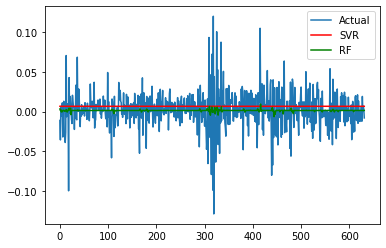

In [26]:
plt.plot(ytest)
plt.plot(p1_t,color='red')
plt.plot(p3_t,color='green')
plt.legend(['Actual','SVR','RF'])

Both models suffer from underestimating the magnitude of changes. SVR is worse as it always predicts the return to be around 0.006 the next day, without major deviations. There is higher variability in RF predictions making it definetely a better model. 

Backward engineering to stock price

In [46]:
start_test=aapl2.loc['2018-12-04'].values


In [58]:
predicted_price_rf=np.empty(633)
predicted_price_rf[0]=start_test

In [59]:
for i in range(1, predicted_price_rf.shape[0]):
  predicted_price_rf[i]=predicted_price_rf[i-1]*(1+p3_t[i-1])

Plotting actual and predicted stock price

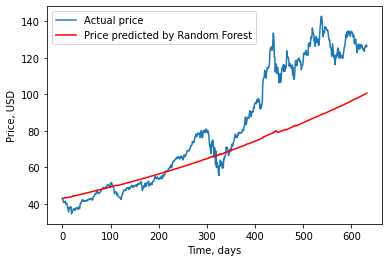

In [63]:
actual_price=aapl2.loc['2018-12-04':].values
plt.plot(actual_price)
plt.plot(predicted_price_rf,color='red')
plt.xlabel('Time, days')
plt.ylabel('Price, USD')
plt.legend(['Actual price','Price predicted by Random Forest'])

The RF model severely underestimated increase and overall variability in Apple price